In [1]:
#setup
%matplotlib notebook
# set this to your working directory
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=10000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(df1['snippet'])
pd.to_pickle(X,'X.pkl')
vocabdict = vec.vocabulary_
vocab = [None] * len(vocabdict) 
for word,index in vocabdict.items():
    vocab[index] = word
pd.to_pickle(vocab,'vocab.pkl')

In [2]:
# tf-idf weights
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=0.9,  # at most 90% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(1,3))

X_tfidf = tfidf.fit_transform(df1['snippet'])
pd.to_pickle(X_tfidf,'X_tfidf.pkl')

<IPython.core.display.Javascript object>


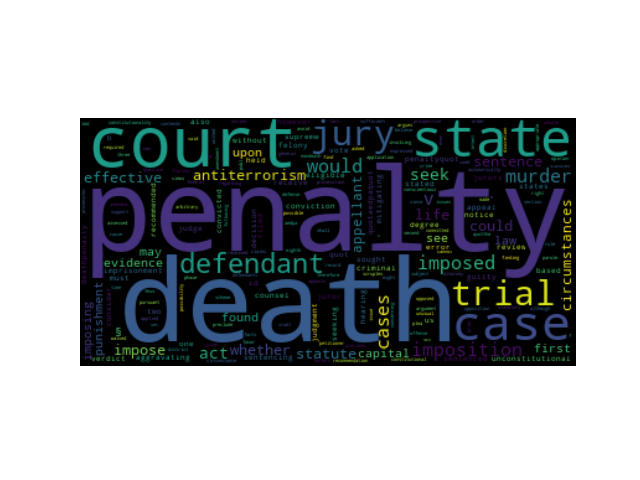

In [3]:
# Our first word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from utils import get_docfreqs

# generate document counts for each word
f = get_docfreqs(df1['snippet']) 
# generate word cloud of words with highest counts
wordcloud = WordCloud().generate_from_frequencies(f) 

plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

In [4]:
#####
# POS tagging 
#####
text = 'Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.'

from nltk.tag import perceptron
from nltk import word_tokenize
tagger = perceptron.PerceptronTagger()
tokens = word_tokenize(text)
tagged_sentence = tagger.tag(tokens)
tagged_sentence

[('Science', 'NN'),
 ('can', 'MD'),
 ('not', 'RB'),
 ('solve', 'VB'),
 ('the', 'DT'),
 ('ultimate', 'JJ'),
 ('mystery', 'NN'),
 ('of', 'IN'),
 ('nature', 'NN'),
 ('.', '.'),
 ('And', 'CC'),
 ('that', 'DT'),
 ('is', 'VBZ'),
 ('because', 'RB'),
 (',', ','),
 ('in', 'IN'),
 ('the', 'DT'),
 ('last', 'JJ'),
 ('analysis', 'NN'),
 (',', ','),
 ('we', 'PRP'),
 ('ourselves', 'PRP'),
 ('are', 'VBP'),
 ('a', 'DT'),
 ('part', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('mystery', 'NN'),
 ('that', 'IN'),
 ('we', 'PRP'),
 ('are', 'VBP'),
 ('trying', 'VBG'),
 ('to', 'TO'),
 ('solve', 'VB'),
 ('.', '.')]

<IPython.core.display.Javascript object>


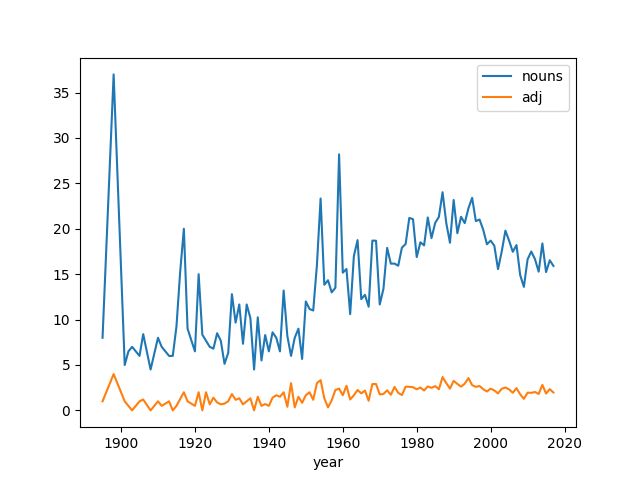

In [5]:
#####
# Our first visualization
# Plot nouns and adjectives over time
#####
from collections import Counter
from nltk import word_tokenize

def get_nouns_adj(snippet):
    tags = [x[1] for x in tagger.tag(word_tokenize(snippet))]
    num_nouns = len([t for t in tags if t[0] == 'N'])
    num_adj = len([t for t in tags if t[0] == 'J'])
    return num_nouns, num_adj

dfs = df1.sample(frac=.1)
dfs['nouns'], dfs['adj'] = zip(*dfs['snippet'].map(get_nouns_adj))
dfs.groupby('year')[['nouns','adj']].mean().plot()

In [6]:
# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
polarity = sid.polarity_scores(text)
polarity

{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'compound': -0.2924}

<IPython.core.display.Javascript object>


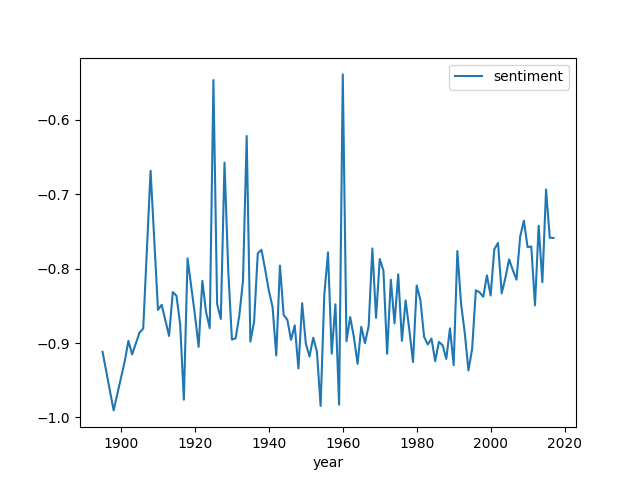

In [7]:
# plot sentiment over time
def get_sentiment(snippet):
    return sid.polarity_scores(snippet)['compound']
dfs['sentiment'] = dfs['snippet'].apply(get_sentiment)
dfs.groupby('year')[['sentiment']].mean().plot()

In [8]:
##########
# N-grams
#####
from nltk import ngrams
grams = []
for i, row in df1.iterrows():
    for n in range(2,4):
        grams += list(ngrams(row['snippet'].lower().split(),n))
    if i == 10:
        break
Counter(grams).most_common()[:8]  

[(('death', 'penalty'), 38),
 (('the', 'death'), 34),
 (('the', 'death', 'penalty'), 25),
 (('death', 'penalty.'), 8),
 (('in', 'the'), 8),
 (('of', 'the'), 7),
 (('the', 'death', 'penalty.'), 6),
 (('(', ')'), 5)]

In [9]:
###
# Collocations: Point-Wise Mutual Information
###
from operator import mul
from functools import reduce
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def get_gmean(phrase, termfreqs):
    words = phrase.split('_')
    n = len(words)
    p = [termfreqs[w]**(1/n) for w in words]
    numerator = termfreqs[phrase]   
    denominator = reduce(mul, p)
    if denominator == 0:
        return 0
    gmean = numerator / denominator
    return gmean

In [12]:
###
# POS-filtered N-grams
###
# Normalize Penn tags
tagdict = { 'NN':'N',
            'NNS':'N',
                                    
            'JJ':'A',
            'JJR':'A',
            'JJS':'A',
            'VBG':'A', # gerunds/participles treated like adjectives

            'RB':'A', # adverbs treated as adjectives
            'RBR':'A',
            'RBS':'A',
            'PDT':'A', # predeterminer            

            'VB':'V',
            'VBD':'V',
            'VBN':'V',
            'VBP':'V',
            'VBZ':'V',
            'MD': 'V', # modals treated as verbs
            'RP': 'V', # particles treated as verbs
            
            'DT':'D',
                        
            'IN':'P',
            'TO':'P',

            'CC': 'C'}

tagpatterns = {'A','N','V','P','C','D',
           'AN','NN', 'VN', 'VV', 
            #'NV',
            'VP',                                    
            'NNN','AAN','ANN','NAN','NPN',
            'VAN','VNN', 'AVN', 'VVN',
            'VPN', 'VDN', 
            #'ANV','NVV','VVV', 'NNV',
            'VVP','VAV','VVN',
            'NCN','VCV', 'ACA',  
            'PAN',
            'NCVN','ANNN','NNNN','NPNN', 'AANN' 'ANNN','ANPN','NNPN','NPAN', 
            'ACAN', 'NCNN', 'NNCN', 'ANCN', 'NCAN',
            'PDAN', 'PNPN',
            'VDNN', 'VDAN','VVDN'}

max_phrase_length = 4

termfreqs = Counter()

docs = pd.read_pickle('processed_corpus.pkl')

for i, doc in enumerate(docs.values()):
    if i > 2000:
        break
    for sentence in doc:    
        # split into words and get POS tags
        tagwords = []
        for (word,tag) in tagger.tag(sentence):
            if tag in tagdict:
                normtag = tagdict[tag]
                stemmed = word#stemmer.stem(word)
                tagwords.append((stemmed,normtag))
            else:
                tagwords.append(None)
        for n in range(1,max_phrase_length+1):            
            rawgrams = ngrams(tagwords,n)
            for rawgram in rawgrams:
                # skip grams that have rare words
                if None in rawgram:
                    continue
                gramtags = ''.join([x[1][0] for x in rawgram])
                if gramtags in tagpatterns:
                     # if tag sequence is allowed, add to counter
                    gram = '_'.join([x[0] for x in rawgram])
                    termfreqs[gram] += 1

# filter out unigrams
grams = [x for x in termfreqs.most_common() if '_' in x[0]]
# make dataframe of geometric mean associations for each gram
gmeans = pd.DataFrame([(gram[0], get_gmean(gram[0],termfreqs)) for gram in grams],
              columns=['ngram','gmean'])
gmeans

/home/elliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: generator 'ngrams' raised StopIteration


,ngram,gmean
0,death_penalty,0.974868
1,penalty_statute,0.185719
2,death_penalty_statute,0.115879
3,impose_the_death,0.097293
4,impose_the_death_penalty,0.076528
5,be_imposed,0.305309
6,seek_the_death,0.066680
7,seek_the_death_penalty,0.049334
8,trial_court,0.363814
9,should_be,0.285581


In [11]:
grams

[('n.j.', '('),
 ('(', ')'),
 (')', 'a.'),
 ('a.', 'd'),
 ('d', 'in'),
 ('in', 're'),
 ('re', 'waiver'),
 ('waiver', 'of'),
 ('of', 'death'),
 ('death', 'penalty.'),
 ('penalty.', 'the'),
 ('the', 'supreme'),
 ('supreme', 'court'),
 ('court', 'of'),
 ('of', 'new'),
 ('new', 'jersey.'),
 ('jersey.', 'september'),
 ('september', '&'),
 ('&', ';'),
 (';', 'and'),
 ('and', 'county'),
 ('county', 'court'),
 ('court', 'judges'),
 ('judges', 're:'),
 ('re:', 'waiver'),
 ('waiver', 'of'),
 ('of', 'the'),
 ('the', 'death'),
 ('death', 'penalty'),
 ('penalty', '*'),
 ('*', 'the'),
 ('the', 'supreme'),
 ('supreme', 'court'),
 ('court', 'is'),
 ('is', 'concerned'),
 ('concerned', 'by'),
 ('by', 'the'),
 ('the', 'excessive&'),
 ('excessive&', ';cases'),
 (';cases', 'where'),
 ('where', 'the'),
 ('the', 'prosecutor'),
 ('prosecutor', 'is'),
 ('is', 'not'),
 ('not', 'seeking'),
 ('seeking', 'the'),
 ('the', 'death'),
 ('death', 'penalty.'),
 ('penalty.', 'it'),
 ('it', 'is'),
 ('is', 'cognizant'),
 (

In [14]:
# Dependency Parsing
import spacy
nlp = spacy.load('en')
doc = nlp(text)
for sent in doc.sents:
    print(sent)
    print(sent.root)
    print([(w, w.dep_) for w in sent.root.children])
    print()

Science cannot solve the ultimate mystery of nature.
solve
[(Science, 'nsubj'), (can, 'aux'), (not, 'neg'), (mystery, 'dobj'), (., 'punct')]

And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.
is
[(And, 'cc'), (that, 'nsubj'), (are, 'advcl'), (., 'punct')]

